In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [46]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [3]:
from w266_common import utils, vocabulary
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data

## Load the data

In [10]:
pwd

'/home/yulia/final-project/Classification'

In [4]:
data_path = '/home/yulia/final-project/data/raw/hein-daily'

In [5]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [13]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [10]:
reload(load_data)
start_time = time.time()
# taking a 30% sample of the full description file
descr = load_data.load_descr_data('/home/yulia/final-project/data/QA/full_descr.txt', p=0.3)
print("It took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

Random congressperson: 1020017231
date 19910313
char_count 1984
word_count 310
speakerid 102112090.0
Party R
Congress 102
Chamber H
State CO
Ethnicity W
Age 56.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. SCHAEFER
Full Name SCHAEFER, DANIEL
match fuzzy
It took 79.7 seconds to create the dictionary


In [11]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.2970141336451574

In [12]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

### Data QA

In [13]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,3000564
1,0,796263
2,1,69374


Target group number of speeches by party:
A: 	 0
D: 	 50375
I: 	 0
N: 	 0
NA: 	 -3000564
P: 	 0
R: 	 18999

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,3000564
1,0,790740
2,1,74897


Target group number of speeches by party:
A: 	 8
D: 	 66335
I: 	 12
N: 	 104
NA: 	 -3000564
P: 	 20
R: 	 8418

 Age
Overall speech counts:


,Category,Count
0,-1,3000564
1,0,562572
2,1,303065


Target group number of speeches by party:
A: 	 8
D: 	 149674
I: 	 114
N: 	 104
NA: 	 -3000564
P: 	 20
R: 	 153145


In [17]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19830524
char_count 2004
word_count 346
speakerid 98108520.0
Party R
Congress 98
Chamber H
State RI
Ethnicity W
Age 37.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Mrs. SCHNEIDER
Full Name SCHNEIDER, CLAUDINE
match fuzzy

Mr. Speaker. today the House is voting on H.R. 2807. a bill that sets a $93.2 million authorization relling for 1982 for title III of the Older Americans Act and authorizes $6.8 million for fiscal year 1982 reimbursement purposes. Title III. as you know. provides both congregate and home delivered nutritional services to millions of seniors throughout the country. In my own State of Rhode Island for instance. in 1982. 54 meal sites served over 1 million meals to seniors over the age of 60. In visiting numerous meal sites throughout the State. I have been continually impressed by the quality of food served. the level of competence displayed by the site workers. and the large number of seniors who rely on the program for their one square mea

In [20]:
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
date 19930223
char_count 134
word_count 28
speakerid 103112360.0
Party D
Congress 103
Chamber H
State MO
Ethnicity B
Age 63.0
Age_lt_med 0.0
NonWhite 1.0
Female 0.0
speaker Mr. CLAY
Full Name CLAY, WILLIAM
match exact

Mr. Speaker. I object to the vote on the ground that a quorum is not present and make the point of order that a quorum is not present.


In [22]:
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
date 20021001
char_count 5758
word_count 969
speakerid 107116070.0
Party R
Congress 107
Chamber H
State IN
Ethnicity W
Age 52.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. SOUDER
Full Name SOUDER, MARK
match exact

Mr. Speaker. we have many. many difficult and complex issues that we each face every day. We just heard from the gentlewoman from Ohio . my friend and colleague. about war. Most of us spend probably the majority of our time. or at least the largest percentage of our time. dealing with economic growth and recovery. jobs. and what we need to do to help attract or keep companies in our district. and the regulatory issues. and many other things. We also work regularly on other issues that come up. For example. I am chairing a hearing Thursday on the West Nile virus which has particularly hit my hometown hard. We just had an hour debate on moral issues. But in addition to these kinds of issues. we deal inside the Federal budget with an incredible array 

# Gender Model

## Split into train, validate, test

### Filter on party if necessary

In [28]:
reload(load_data)
# all_speeches_d, all_speech_ids_d, gender_d = load_data.filter_data(all_speeches, all_speech_ids, gender, party, 'D')
# len(all_speeches_d), len(all_speech_ids_d), len(gender_d)

In [37]:
reload(explore_data)
# explore_data.get_counts(gender_d)

,Category,Count
0,0,103864
1,1,2172


### Split into train/val/test

#### Split by congress

In [9]:
# reload(preprocess_data)
# train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_by_congress(all_speeches, all_speech_ids, gender, descr, congress)

In [23]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 28624 ones and 28624 zeroes
Training speech list size: 57248
Training target list size: 57248
Validation split: 9541 ones and 9541 zeroes
Validation speech list size: 19082
Validation target list size: 19082
Test split: 9543 ones and 9543 zeroes
Test speech list size: 19086
Test target list size: 19086


In [24]:
sum(train_target), sum(val_target), sum(test_target)

(28624, 9541, 9543)

In [25]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

21666

In [26]:
# random speech from a train set where gender=1
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19970430
char_count 2766
word_count 444
speakerid 105115120.0
Party R
Congress 105
Chamber H
State OH
Ethnicity W
Age 47.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Ms. PRYCE of Ohio
Full Name PRYCE, DEBORAH
match exact

Mr. Speaker. I thank the distinguished vice chairman of the committee. the gentleman from California for yielding me this time. Mr. Speaker. I- rise to express my support for both this open rule and the Housing Opportunity Responsibility Act. First. I want to commend the chairman. the gentleman from New York . and the Subcommittee on Housing and Community Opportunity of the Committee on Banking and Financial Services for crafting legislation that follows our basic principles of. No. 1. making the American dream of affordable housing more attainable. No. 2. empowering individuals to improve their lives. No. 3. returning more decisionmaking authority to States and localities where it belongs. Mr. Speaker. H.R. 2 does all of these things. fun

## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [27]:
reload(explore_data)

<module 'helpers.explore_data' from '/home/yulia/final-project/Classification/helpers/explore_data.py'>

In [28]:
explore_data.get_num_words_per_sample(train)

251.0

In [29]:
explore_data.get_num_words_per_sample(val)

251.0

In [30]:
explore_data.get_num_words_per_sample(test)

253.0

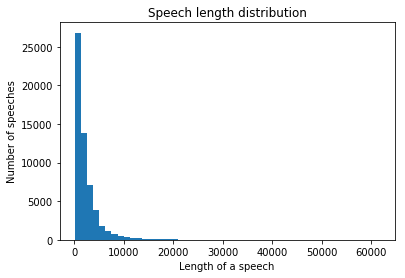

In [31]:
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

In [32]:
# take a sample to avoid running out of memory
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

11449

['the', 'to', 'of', 'and', 'in', 'that', 'is', 'for', 'this', 'we', 'it', 'have', 'on', 'are', 'as', 'not', 'be', 'our', 'with', 'will', 'from', 'by', 'they', 'has', 'mr', 'was', 'would', 'my', 'their', 'an', 'at', 'who', 'bill', 'but', 'all', 'or', 'do', 'he', 'his', 'people', 'which', 'what', 'about', 'president', 'been', 'so', 'there', 'these', 'you', 'more']


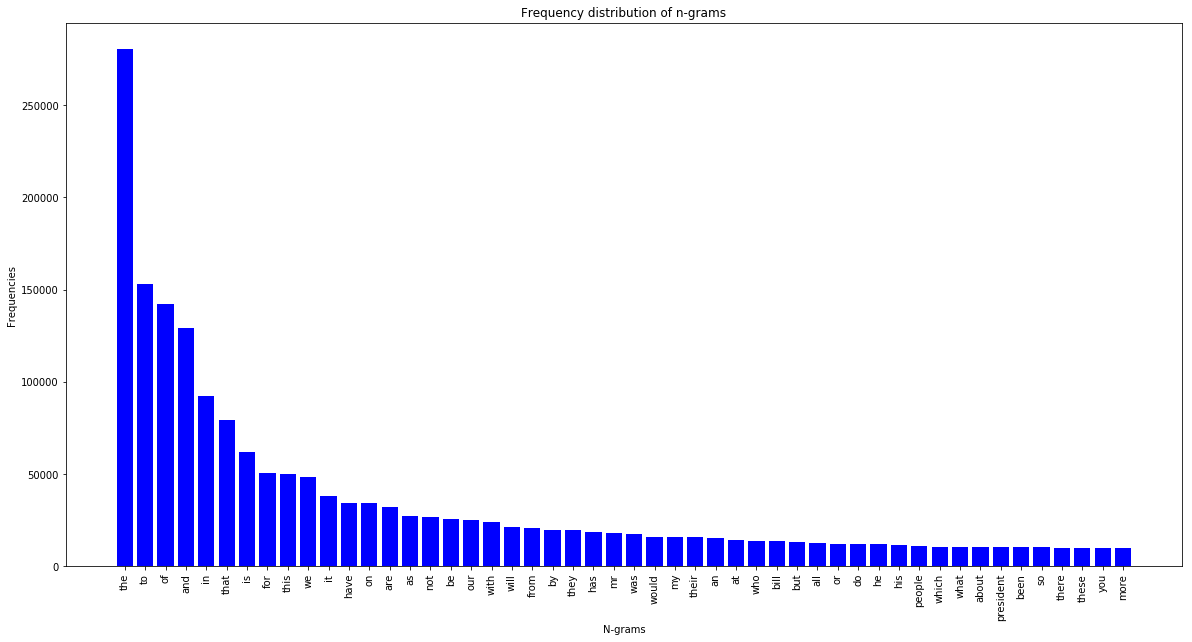

In [33]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'and the', 'on the', 'for the', 'that the', 'mr speaker', 'we have', 'we are', 'to be', 'that is', 'that we', 'by the', 'with the', 'of this', 'going to', 'in this', 'united states', 'the united', 'mr president', 'this bill', 'is the', 'at the', 'this is', 'will be', 'of our', 'want to', 'from the', 'has been', 'is not', 'my colleagues', 'have been', 'the senate', 'they are', 'to do', 'do not', 'the gentleman', 'there is', 'the bill', 'one of', 'the house', 'as the', 'the american', 'to make', 'would be', 'we can', 'have to', 'more than']


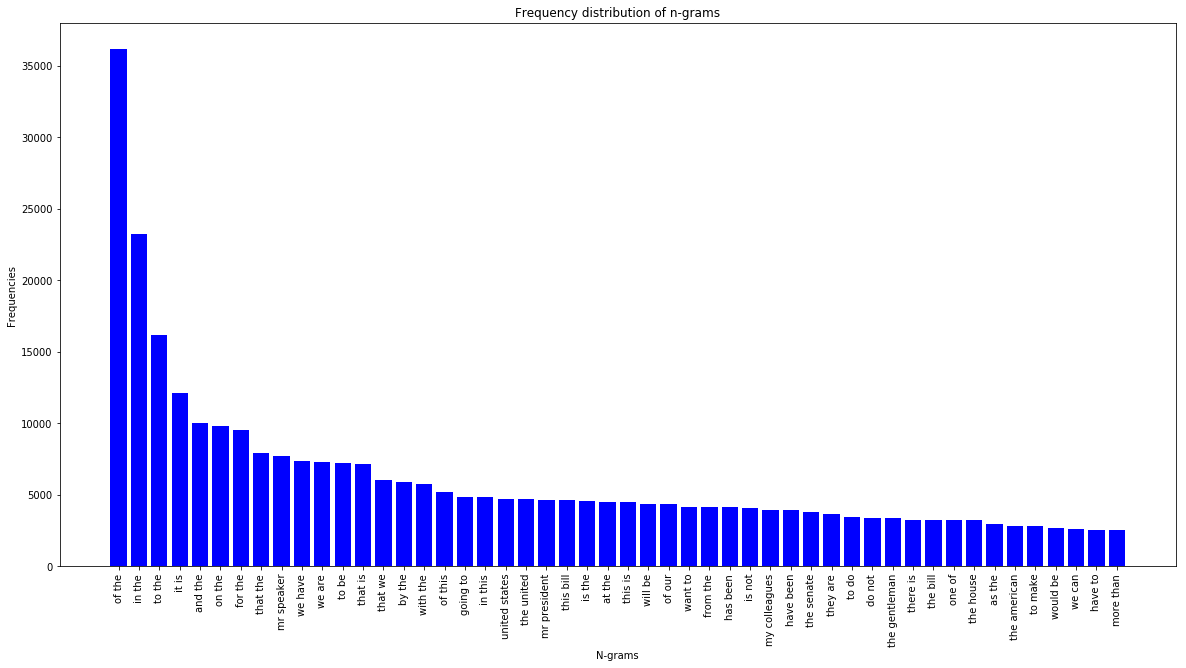

In [34]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'the gentleman from', 'one of the', 'are going to', 'would like to', 'my colleagues to', 'the american people', 'the senator from', 'be able to', 'we need to', 'the department of', 'mr speaker rise', 'as well as', 'we are going', 'of the united', 'urge my colleagues', 'is going to', 'in this country', 'in the united', 'it is not', 'member of the', 'the federal government', 'going to be', 'that we have', 'the committee on', 'some of the', 'in order to', 'percent of the', 'chairman of the', 'that we are', 'in support of', 'rise today to', 'ask unanimous consent', 'there is no', 'part of the', 'men and women', 'the fact that', 'speaker rise today', 'we do not', 'the people of', 'that is the', 'members of the', 'of the senate', 'and it is', 'and that is', 'thank the gentleman', 'the state of', 'unanimous consent that', 'of my colleagues', 'we have to']


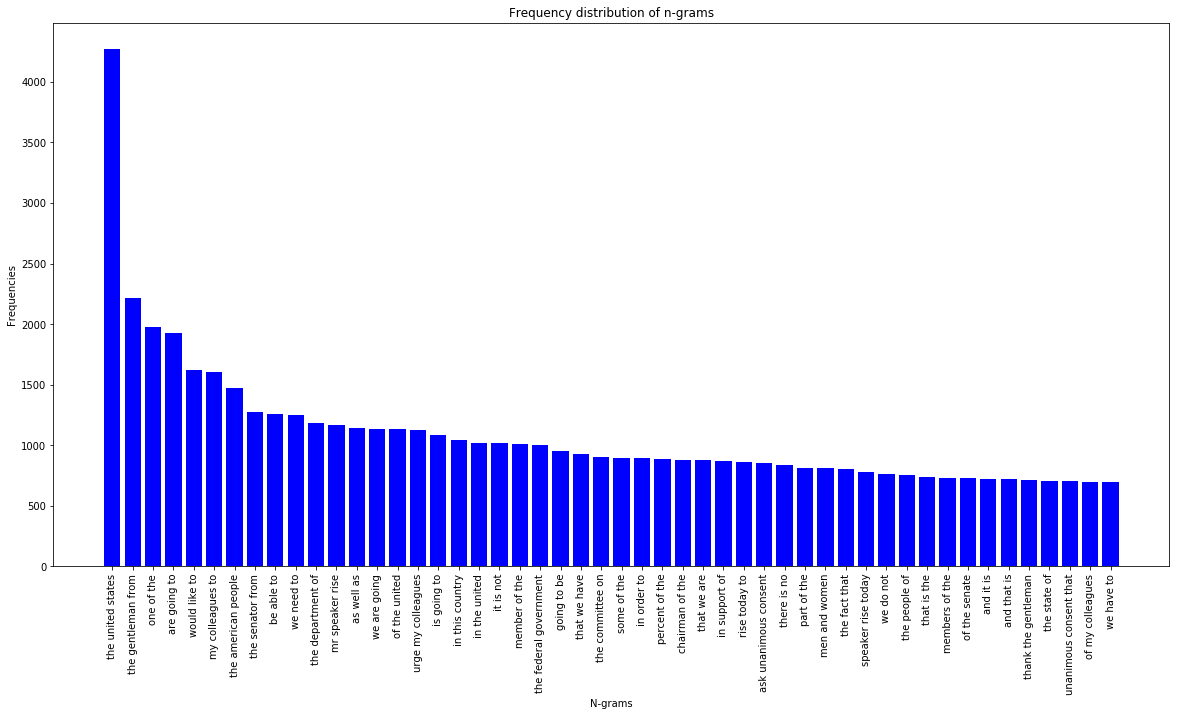

In [35]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [37]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 97 top 5 (3, 3) ngrams are:
the united states
the senator from
would like to
the gentleman from
one of the
--------------------

For Congress 98 top 5 (3, 3) ngrams are:
the united states
would like to
the senator from
the gentleman from
the soviet union
--------------------

For Congress 99 top 5 (3, 3) ngrams are:
the united states
the gentleman from
would like to
members of the
one of the
--------------------

For Congress 100 top 5 (3, 3) ngrams are:
the united states
the gentleman from
would like to
one of the
the senator from
--------------------

For Congress 101 top 5 (3, 3) ngrams are:
the united states
the gentleman from
would like to
one of the
the senator from
--------------------

For Congress 102 top 5 (3, 3) ngrams are:
the united states
the gentleman from
one of the
would like to
the senator from
--------------------

For Congress 103 top 5 (3, 3) ngrams are:
the united states
the gentleman from
would like to
my colleagues to
one of the
-------------------

## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [38]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 10000

# Output number of top/bottom scoring ngrams
TOP_N = 5

model_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [39]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **model_params)

Total vocabulary size: 405088
Number of stop words 3047999

Top 5 ngrams by differentiating score:
mr president 	 1787.8
women 	 1246.5
rise 	 1104.2
our 	 1098.1
president 	 1063.4

Bottom 5 ngrams by differentiating score:
the cops 	 0.0
analyzed this 	 0.0
senate came 	 0.0
dr ronald 	 0.0
and enhancing 	 0.0


In [41]:
len(train), len(val), len(test)

(57248, 19082, 19086)

In [42]:
train_vec.shape, val_vec.shape, test_vec.shape

((57248, 10000), (19082, 10000), (19086, 10000))

### Saving processed files

In [40]:
pwd

'/home/yulia/final-project/Classification'

In [43]:
data_path = '/home/yulia/final-project/Classification/data'

In [44]:
scipy.sparse.save_npz(os.path.join(data_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'test_vec.npz'), test_vec)

In [ ]:
train_vec = scipy.sparse.load_npz(os.path.join(data_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(data_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(data_path, 'test_vec.npz'))

In [ ]:
train_vec.shape, val_vec.shape, test_vec.shape

In [47]:
with open(os.path.join(data_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(data_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(data_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(data_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(data_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(data_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(data_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(data_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(data_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [ ]:
sum(train_target), sum(val_target), sum(test_target)

In [ ]:
with open(os.path.join(data_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(data_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(data_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(data_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(data_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(data_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [ ]:
sum(train_target), sum(val_target), sum(test_target)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [48]:
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [49]:
logs_base_dir = "/home/yulia/final-project/Classification/logs"

In [50]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    Returns
        An MLP model instance.
    """
    op_units, op_activation = 1, 'sigmoid'
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    
    return model

In [51]:
class TimeHistory(tf.keras.callbacks.Callback):
    """
    https://stackoverflow.com/questions/43178668/
    record-the-computation-time-for-each-epoch-in-keras-during-model-fit
    """
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [53]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """
    Trains n-gram model on the given dataset.

    Arguments:
        data: tuples of vectorized training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    Returns:
        tuple with accuracy and loss on validation data for the last interation
    """
    # Get the data.
    (x_train, train_labels), (x_val, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = 2

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=2),
        tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, 
                                       histogram_freq=0, 
                                       write_graph=True, 
                                       write_images=True),
        TimeHistory()]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    train_pred_probs = model.predict(x_train)
    val_pred_probs = model.predict(x_val)

    return history, train_pred_probs, val_pred_probs

In [54]:
history, train_pred_probs, val_pred_probs = train_ngram_model(((train_vec, train_target), (val_vec, val_target)))

Train on 57248 samples, validate on 19082 samples
Epoch 1/1000
 - 13s - loss: 0.5797 - acc: 0.7035 - val_loss: 0.5516 - val_acc: 0.7165
Epoch 2/1000
 - 12s - loss: 0.5081 - acc: 0.7479 - val_loss: 0.5421 - val_acc: 0.7219
Epoch 3/1000
 - 12s - loss: 0.4818 - acc: 0.7659 - val_loss: 0.5441 - val_acc: 0.7212
Epoch 4/1000
 - 12s - loss: 0.4653 - acc: 0.7733 - val_loss: 0.5483 - val_acc: 0.7194
Validation accuracy: 0.7194214443055454, loss: 0.548296949121515


## Model evaluation

In [55]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

13728

Confusion matrix, without normalization
[[6965 2576]
 [2778 6763]]


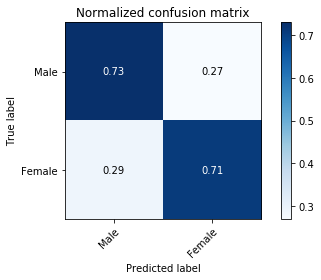

In [56]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

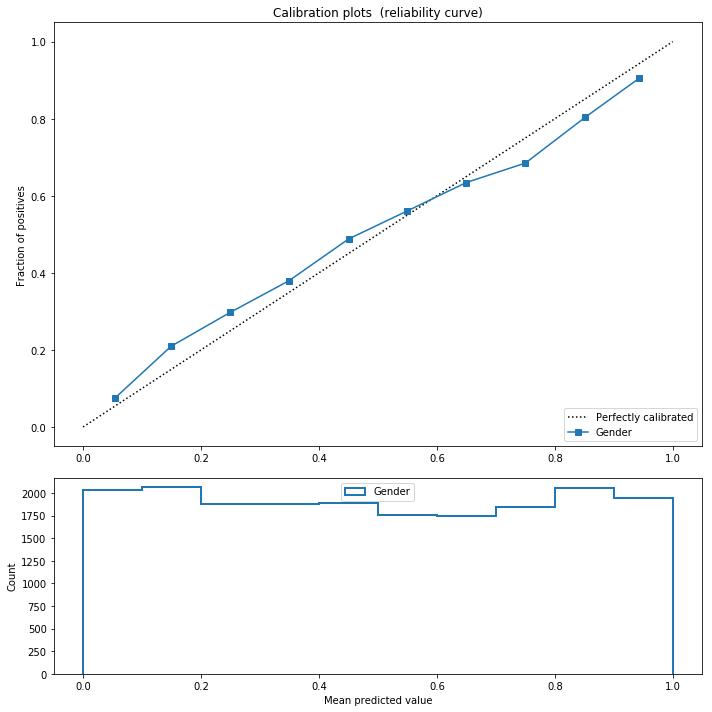

In [57]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [64]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.29635258358662614

In [68]:
val_target_sample = np.array(val_target)[val_random==1]
val_ids_sample = np.array(val_ids)[val_random==1]
val_pred_probs_sample = val_pred_probs[val_random==1]
val_target_sample.shape, val_ids_sample.shape, val_pred_probs_sample.shape

((5655,), (5655,), (5655, 1))

In [88]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs_sample, 
                                   val_ids_sample, 
                                   descr)

Finished building main df
<class 'numpy.ndarray'>
(2345,)
['1070012922' '1110022212' '1030063105' '1100187234' '1110116840'
 '1040124266' '1100045196' '1060097569' '1040080127' '1090092949']


KeyError: "None of [['1070012922' '1110022212' '1030063105' ... '980254296' '1110118799'\n '1120064016']] are in the [index]"

In [216]:
reload(explore_data)
explore_data.ngrams_by_bin(val, val_pred_probs)


In 0.4 bin top 10 ngrams:

the senator from
the united states
would like to
the gentleman from
ask unanimous consent
of the bill
in the record
in order to
unanimous consent that
ask unanimous consent that
--------------------

In 0.6 bin top 10 ngrams:

the united states
the gentleman from
would like to
the soviet union
the department of
one of the
the federal government
of the united
of the united states
of the american
--------------------

In 1.0 bin top 10 ngrams:

the united states
would like to
the soviet union
the gentleman from
one of the
thank the gentleman
in support of
my colleagues to
the people of
the gentleman for
--------------------


In [242]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)


True positive (Predicted prob: 0.95):

Ethnicity W
Age_lt_med 1.0
speaker Mrs. MARTIN of Illinois
char_count 1292
Party R
word_count 238
match exact
speakerid 97108370.0
Female 1.0
Congress 97
date 19821130
State IL
Full Name MARTIN, LYNN
NonWhite 0.0
Chamber H
Age 43.0

 I thank the gentleman for yielding. Mr. Speaker. I do not know why any of us should be surprised at the courage and the daring and. almost. occasionally fey part of PAUL FINDLEY. His hero is Abraham Lincoln. He is a Lincoln collector. His office is a repository. really. of Lincoln memorabilia. I think the spirit that moved the greatest son of Illinois is part of. what moved PAUL FINDLEY. I think he cared about peoples rights. If he saw that a right was being abrogated or abridged. even in an unpopular area. lie moved in. If It were equal rights in this Nation or rights in other nations. he moved in. He would represent the farmers. He does represent the farmers in his district. But if somebody was getting too much mon